<img src="Resources/small_GA_logo.png" style="float: left; margin: 20px">

#  Book Reviews Capstone Project: Goodreads API


*Delphine Defforey*

___


<font color=navy>
   In this notebook, I use the ISBNs collected from the LibraryThing website to collect Goodreads IDs for each book using the BetterReads package, which provides a Python interface for the Goodreads API. I then use those IDs to do a get request to collect "Goodreads shelves" for each book. These shelves include both genre information and categories such as "to-read", "read", "currently reading", which are not useful for the purpose of this project. I then apply a series of filters to remove this extraneous information, and use the counts data provided by Goodreads to identify the main genres each book corresponds to. The threshold I have set for a given genre to be considered a "main" genre is 25% of the total number of counts. This is an arbitrary threshold I have set, and it is important to note that my approach for assigning genres to each book is a potential limitation of this work as it involved substantial simplifications. Non-fiction books in particular were all assigned to one category, as I chose to focus on fiction books. The latter fall into 6 genres: fantasy, science-fiction, mystery, thriller, romance and general fiction (for those that did not clearly fit into the previous genres). 
    </font>

### Imports and Settings

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from requests import get
from betterreads import client
from tqdm import tqdm_notebook

### Configs

In [7]:
CLEANER_BOOK_INFO_PATH = '/Users/ddefforey1/work/dsi-course/capstone_datasets/cleaner_book_info.csv'
GOODREADS_IDS_PATH = '/Users/ddefforey1/work/dsi-course/capstone_datasets/goodreads_ids.csv'
RAW_GOODREADS_IDS_GENRES_PATH = '/Users/ddefforey1/work/dsi-course/capstone_datasets/raw_goodreads_ids_genres.csv'
CLEAN_BOOK_GENRES_PATH = '/Users/ddefforey1/work/dsi-course/capstone_datasets/clean_book_genres.csv'

### Using the Goodreads API to get Goodreads Book Identifiers

<font color=navy>
Loading the dataset with the book titles, author names and ISBNs. Here it is important to set the data type to object to avoid the leading zeros in the isbn column from being dropped
</font>

In [10]:
book_info = pd.read_csv(CLEANER_BOOK_INFO_PATH, dtype=object)
book_info.head()

,id,book_title,author,isbn
0,4979986,The Hunger Games,Suzanne Collins,0439023483
1,8384326,Twilight (2005),Stephenie Meyer,0316015849
2,1541442,The Girl with the Dragon Tattoo (2005),Stieg Larsson,0307454541
3,393681,The Book Thief (2007),Markus Zusak,0375842209
4,8662515,Catching Fire,Suzanne Collins,0439023491


In [9]:
book_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
id            5000 non-null object
book_title    5000 non-null object
author        5000 non-null object
isbn          3638 non-null object
dtypes: object(4)
memory usage: 156.3+ KB


In [5]:
book_info['id'] = book_info.id.astype(int)

In [11]:
# removing the missing isbns for now:
book_info = book_info.dropna().reset_index(drop=True)

In [8]:
# fixing incorrect ISBN entries in book_info:
book_info.loc[book_info.book_title == 'The Glass Castle', 'isbn'] = '1844081826'
book_info.loc[book_info.book_title == 'Atonement (2001)', 'isbn'] = '9780099429791'
book_info.loc[book_info.book_title == "The Handmaid's Tale (1985)", 'isbn'] = '9780385490818'
book_info.loc[book_info.book_title == 'Thirteen Reasons Why', 'isbn'] = '0141328290'

book_info.loc[[43, 59, 66, 69]]

,id,book_title,author,isbn
43,7903,The Glass Castle,Jeannette Walls,1844081826
59,2348,Atonement (2001),Ian McEwan,9780099429791
66,1667444,The Handmaid's Tale (1985),Margaret Atwood,9780385490818
69,3159496,Thirteen Reasons Why,Jay Asher,0141328290


In [9]:
# I'm going to use a regex here to identify problematic ISBNs (that are not 10 or 13 digits in length) 
problem_isbns = book_info[- book_info.isbn.str.contains(r'^[\d]{10,13}$')].copy()

In [10]:
good_isbns = book_info[book_info.isbn.str.contains(r'^[\d]{10,13}$')].copy()

In [11]:
problem_isbns.shape

(372, 4)

In [12]:
good_isbns.shape

(3266, 4)

In [13]:
# fixing incorrect ISBN entries in the good_isbns df:
# note that these entries are still incorrect in the book_info df:

good_isbns.isbn.iloc[284] = '9780060590284'
good_isbns.isbn.iloc[441] = '9780060590284'
good_isbns.isbn.iloc[1023] = '9780194790185'
good_isbns.isbn.iloc[1906] = '9780515134506'
good_isbns.isbn.iloc[2065] = '9780385536097'

In [14]:
# I will use the valid ISBNs to move on to the next step and get Goodreads book IDs
# if time allows, I will manually correct the invalid ISBNs and add them to my dataset
good_list = list(good_isbns.isbn)

In [15]:
good_list_lb_ids = list(good_isbns.id)

In [16]:
len(good_list)

3266

In [17]:
isbn_list = list(book_info.isbn)

In [18]:
def acquire_goodreads_id(isbn_number):
    """
    Collects Goodreads IDs using ISBNs and the Goodreads python connector. A 1 second delay is included in
    the function to avoid being blocked.
    """
    goodreads_id = []
    for number in tqdm_notebook(isbn_number):
        base_url = 'https://www.goodreads.com/book/isbn_to_id'
        params = {'key': 'DOIHCwqd9wgM2dVm6827Og', 'isbn': number}

        req_ = get(base_url, params=params)
        json_ = req_.json()
        goodreads_id.append(json_)
        time.sleep(1)
    return goodreads_id

In [19]:
goodreads_ids = acquire_goodreads_id(good_list)

In [20]:
# making a dataframe with ISBNs and their corresponding Goodreads IDs
goodreads_ids = pd.DataFrame({
    'isbn': good_list,
    'goodreads_id': goodreads_ids
})

In [21]:
goodreads_ids.head()

,isbn,goodreads_id
0,0439023483,2767052
1,0316015849,41865
2,0307454541,5291539
3,0375842209,39395800
4,0439023491,6148028


In [22]:
# saving this dataframe to avoid having to collect ISBNs again
goodreads_ids.to_csv(GOODREADS_IDS_PATH, index=False)

### Using the Python Interface for Goodreads to get Book Genre Information

<font color=navy>
    Here, it is important to use the BetterReads package rather than the goodreads package because the former provides count data for popular shelves, whereas the latter doesn't.
    </font>

In [23]:
gc = client.GoodreadsClient('DOIHCwqd9wgM2dVm6827Og', 'tWeUy3YeVrZ3a8E6rXjYLc3RvVhrM5zzHUNIdNMJBA')

In [24]:
# here I'm setting the data type to object to avoid losing any leading zeroes in ISBNs
goodreads_ids = pd.read_csv(GOODREADS_IDS_PATH, dtype=object)

In [25]:
# adding LibraryThing book IDs to the dataframe to facilitate merging later on
goodreads_ids['id'] = good_list_lb_ids

In [26]:
goodreads_ids = goodreads_ids[['id', 'goodreads_id', 'isbn']]

In [27]:
goodreads_ids.head()

,id,goodreads_id,isbn
0,4979986,2767052,0439023483
1,8384326,41865,0316015849
2,1541442,5291539,0307454541
3,393681,39395800,0375842209
4,8662515,6148028,0439023491


In [28]:
goodreads_ids.shape

(3266, 3)

In [29]:
def get_book_titles(book_id):
    book_titles = []
    for number in tqdm_notebook(book_id):
        book_titles.append((gc.book(number)).title)
        time.sleep(1)
    return book_titles

In [30]:
# getting book titles from Goodreads to confirm that they match those from the LibraryThing dataset
goodreads_book_titles = get_book_titles(goodreads_ids.goodreads_id)

In [31]:
# verifying that the book titles are correct
goodreads_book_titles[1:20]

['Twilight (Twilight, #1)',
 'The Girl with the Dragon Tattoo (Millennium, #1)',
 'The Book Thief',
 'Catching Fire (The Hunger Games, #2)',
 'Harry Potter and the Deathly Hallows (Harry Potter, #7)',
 'The Help',
 'The Kite Runner',
 'The Da Vinci Code',
 'The Guernsey Literary and Potato Peel Pie Society',
 'The Curious Incident of the Dog in the Night-Time',
 'New Moon (Twilight, #2)',
 'The Graveyard Book',
 'The Lovely Bones',
 'Pride and Prejudice',
 'The Giver (The Giver, #1)',
 'To Kill a Mockingbird',
 'Eclipse (Twilight, #3)',
 'The Lightning Thief (Percy Jackson and the Olympians, #1)',
 'Eat, Pray, Love']

In [32]:
goodreads_ids['goodreads_book_titles'] = goodreads_book_titles

In [33]:
def get_book_shelves(book_id):
    book_shelves = []
    for number in tqdm_notebook(book_id):
        book_shelves.append((gc.book(number)).popular_shelves)
        time.sleep(1)
    return book_shelves

In [35]:
raw_book_shelves = get_book_shelves(goodreads_ids.goodreads_id)

In [36]:
goodreads_ids['goodreads_shelves'] = raw_book_shelves

In [37]:
# saving a copy of the dataset to avoid having to get Goodreads shelves information again
goodreads_ids.to_csv(RAW_GOODREADS_IDS_GENRES_PATH, index=False)

In [38]:
goodreads_ids_genres = pd.read_csv(RAW_GOODREADS_IDS_GENRES_PATH, dtype=object)

In [39]:
goodreads_ids_genres.head()

,id,goodreads_id,isbn,goodreads_book_titles,goodreads_shelves
0,4979986,2767052,0439023483,"The Hunger Games (The Hunger Games, #1)","[{'@name': 'to-read', '@count': '870985'}, {'@..."
1,8384326,41865,0316015849,"Twilight (Twilight, #1)","[{'@name': 'to-read', '@count': '599873'}, {'@..."
2,1541442,5291539,0307454541,"The Girl with the Dragon Tattoo (Millennium, #1)","[{'@name': 'to-read', '@count': '745270'}, {'@..."
3,393681,39395800,0375842209,The Book Thief,"[{'@name': 'to-read', '@count': '1013995'}, {'..."
4,8662515,6148028,0439023491,"Catching Fire (The Hunger Games, #2)","[{'@name': 'to-read', '@count': '221799'}, {'@..."


### Processing Book Genre Information

<font color=navy>
    Below, I'm showing the different steps that allowed me to build the function that takes the raw Goodreads shelves in each entry of the goodreads_shelves column, removes extraneous information, assigns book genres based on keywords then returns the main book genre(s) for each book.
    </font>

In [40]:
# sampling a book at random
# I improved my filters below by randomly sampling books 50 times and checking the main genres they returned
goodreads_ids_genres.goodreads_shelves.sample()

1500    [{'@name': 'politics', '@count': '727'}, {'@na...
Name: goodreads_shelves, dtype: object

In [51]:
# create a dataframe from the list of dictionaries
# because each entry was read as a string, I had to use eval:
genre_info = pd.DataFrame(eval(goodreads_ids_genres.goodreads_shelves[1]))

In [52]:
genre_info.head()

,@count,@name
0,599873,to-read
1,21136,currently-reading
2,18033,young-adult
3,16141,fantasy
4,12163,favorites


In [53]:
# renaming the column names so they are cleaner
genre_info.rename(columns={'@count': 'counts', '@name': 'genre'}, inplace=True)

In [54]:
genre_info.head()

,counts,genre
0,599873,to-read
1,21136,currently-reading
2,18033,young-adult
3,16141,fantasy
4,12163,favorites


In [55]:
# generating a black list for goodreads shelves (i.e. categories that don't correspond to book genres)
# this filter will allow me to remove them
genre_filter = ['to-read', 'favorites', 'currently-reading', 'books-i-own', 'owned', 'series',
       'favourites', 'owned-books', 'book-club', 'kindle', 'my-books', 'favorite-books',
       'read-in-2012', 're-read', 'all-time-favorites', '5-stars', 'books', 'bookclub', 'audible', 'audio-books',
       'favorite', 'audiobook', 'novels', 'ebook', 'i-own', 'audiobooks', 'meh', 'dnf', 'have', 'audio-book',
       'read-in-2011', 'my-favorites', 'default', 'library', 'books-i-have', 'did-not-finish', 'recommended',
       'translated', 'must-read', 'book-club-books', 'millennium', 'five-stars', 'didn-t-finish', 'never-finished',
       'ebooks', 'read-2012', 'reread', 'faves', 'my-library', 'read-in-2010', 'audio','unfinished',
       'shelfari-favorites', 'favs', 'finished', 'own-it', 'favorite-series', 'english', 'abandoned', 'paperback',
       'loved', 'novel', 'read-more-than-once', 'read-in-2013', 'borrowed', 'on-my-shelf', 'read-2010',
       'favourite', 'want-to-buy', 'to-buy', 'bookshelf', 'my-bookshelf', '4-stars', 'already-read', 'page-turner', 'best-books',
       'favourite-books', 'trilogy', 'read-2011', 're-reads', '5-star', 'reviewed', 'e-book', 'never-again',
       'read-in-2009', 'read-in-2008', '4-star', '3-star', '2-star', '1-star','0-star', '3-stars', '2-star', '1-star',
       '0-star', 'read-in-', '-star', '-stars', 'movie', 'chick-lit', 'guilty-pleasure', 'recommend', 'wish-list', 'book-group'
       'on-hold','read-', 'stand-alone', 'made-me-cry', 'gave-up-on', 'gave-up', 'i-only-watched-the-movie', 'owned-to-read',
       'couldn-t-finish', 'could-not-finish', 'best-ever']

In [56]:
# assumption here: I'm treating 'love' as I would 'romance', ie as a genre
# however I'm treating 'loved' as a goodreads shelf, ie "popular loved books"
# this is based on info from the goodreads website

In [57]:
# creating the filter to remove extraneous information
# calculating the fraction of genres that aren't useful
search_pattern = '|'.join(genre_filter)
m_bad_genres = genre_info.genre.str.contains(search_pattern)
m_bad_genres.mean()

0.6

In [58]:
genre_info[~ m_bad_genres].head()

,counts,genre
2,18033,young-adult
3,16141,fantasy
5,10048,romance
6,7612,vampires
7,7256,ya


In [59]:
# applying the filter and removing extraneous information
clean_genre = genre_info[~ m_bad_genres].copy()
clean_genre.reset_index(drop=True, inplace=True)

In [12]:
# checking what is left after filtering out unnecessary information
clean_genre.head(10)

NameError: name 'clean_genre' is not defined

In [61]:
clean_genre.shape

(40, 2)

In [62]:
# generating a white list for book genres
genre_dict = {
    'young-adult-fiction': 'fiction',
    'ya-paranormal': 'fantasy',
    'ya-fantasy': 'fantasy',
    'ya-dystopian': 'science-fiction',
    'teen-fiction': 'fiction',
    'young-adult-fantasy': 'fantasy',
    'ya-fiction': 'fiction',
    'ya-historical-fiction': 'fiction',
    'horror': 'fiction',
    'horror-suspense': 'fiction',
    'terror': 'fiction',
    'fiction-horror': 'fiction',
    'gothic': 'fiction',
    'adult-fiction': 'fiction',
    'southern-fiction': 'fiction',
    'literary-fiction': 'fiction',
    'juvenile-fiction': 'fiction',
    'fiction': 'fiction',
    'realistic-fiction': 'fiction',
    'modern-fiction': 'fiction',
    'general-fiction': 'fiction',
    'popular-fiction': 'fiction',
    'metafiction': 'fiction',
    'animal-fiction': 'fiction',
    'fiction-historical': 'fiction',
    'classic-fiction': 'fiction',
    'contemporary-fiction': 'fiction',
    'historical-fiction': 'fiction',
    'historical-fic': 'fiction',
    'historic-fiction': 'fiction',
    'dystopian': 'science-fiction',
    'dystopia': 'science-fiction',
    'post-apocalyptic': 'science-fiction',
    'distopia': 'science-fiction',
    'distopian': 'science-fiction',
    'dystopian-fiction': 'science-fiction',
    'speculative-fiction': 'science-fiction',
    'dystopias': 'science-fiction',
    'science-fiction-fantasy': 'science-fiction',
    'adventure': 'fiction',
    'science-fiction': 'science-fiction',
    'sci-fi': 'science-fiction',
    'futuristic': 'science-fiction',
    'future': 'science-fiction',
    'sci-fi-fantasy': 'science-fiction',
    'scifi': 'science-fiction',
    'scifi-fantasy': 'science-fiction',
    'sf': 'science-fiction',
    'space opera': 'science-fiction',
    'space-opera': 'science-fiction',
    'sff': 'science-fiction',
    'aliens': 'science-fiction',
    'sf-fantasy': 'science-fiction',
    'sci-fi-and-fantasy': 'science-fiction',
    'sciencefiction': 'science-fiction',
    'far-future': 'science-fiction',
    'first-contact': 'science-fiction',
    'utopia': 'science-fiction',
    'science-fiction-and-fantasy': 'science-fiction',
    'hard-sci-fi': 'science-fiction',
    'sf-f': 'science-fiction',
    'fantasy': 'fantasy',
    'high-fantasy': 'fantasy',
    'fantasy-sci-fi': 'fantasy',
    'paranormal-fantasy': 'fantasy',
    'paranormal': 'fantasy',
    'vampires': 'fantasy',
    'vampire': 'fantasy',
    'vamps': 'fantasy',
    'urban-fantasy': 'fantasy',
    'supernatural': 'fantasy',
    'werewolves': 'fantasy',
    'fairy-tales': 'fantasy',
    'fairy tales': 'fantasy',
    'fairy-tale': 'fantasy',
    'fantasy-paranormal': 'fantasy',
    'epic fantasy': 'fantasy',
    'epic-fantasy': 'fantasy',
    'fantasia': 'fantasy',
    'fantasy-fiction': 'fantasy',
    'mythology': 'fantasy',
    'magic': 'fantasy',
    'witches': 'fantasy',
    'wizards': 'fantasy',
    'dragons': 'fantasy',
    'shapeshifters': 'fantasy', 
    'shifters': 'fantasy',
    'werewolf': 'fantasy',
    'ghosts': 'fantasy',
    'ghost-stories': 'fantasy',
    'fiction-fantasy': 'fantasy',
    'fantasy-scifi': 'fantasy',
    'magical-realism': 'fantasy',
    'fantasy-science-fiction': 'fantasy',
    'genre-fantasy': 'fantasy',
    'fantasy-and-sci-fi': 'fantasy',
    'dark-fantasy': 'fantasy',
    'horror-supernatural': 'fantasy',
    'fantastic': 'fantasy',
    'romance': 'romance',
    'pnr': 'romance',
    'love': 'romance',
    'love-triangle': 'romance',
    'paranormal-romance': 'romance',
    'romantic': 'romance',
    'historical-romance': 'romance',
    'gothic-romance': 'romance',
    'thriller': 'thriller',
    'thrillers': 'thriller',
    'psychological-thriller': 'thriller',
    'thriller-mystery': 'thriller',
    'thriller-suspense': 'thriller',
    'suspense': 'thriller',
    'suspense-thriller': 'thriller',
    'conspiracy': 'thriller',
    'medical-thriller': 'thriller',
    'mystery': 'mystery',
    'mystery-thriller': 'mystery',
    'mystery-suspense': 'mystery',
    'mystery-crime': 'mystery',
    'mysteries': 'mystery',
    'historical-mystery': 'mystery',
    'historical mystery': 'mystery',
    'forensic-mystery': 'mystery',
    'classic-mystery': 'mystery',
    'classic mystery': 'mystery',
    'fiction-mystery': 'mystery',
    'murder-mystery': 'mystery',
    'cozy-mystery': 'mystery',
    'golden-age-mystery': 'mystery',
    'mysteries-thrillers': 'mystery',
    'mystery-thrillers': 'mystery',
    'classic-mysteries': 'mystery',
    'mystery-classic': 'mystery',
    'mystery-detective': 'mystery',
    'mystery-cozy': 'mystery',
    'golden-age-mysteries': 'mystery',
    'mystery-thriller-suspense': 'mystery',
    'forensic-mysteries': 'mystery',
    'crime-mystery-thriller': 'thriller',
    'crime': 'thriller',
    'crime-fiction': 'thriller',
    'crime-thriller': 'thriller',
    'crime-mystery': 'thriller',
    'horror-thriller': 'thriller',
    'murder-mystery': 'thriller',
    'murder': 'thriller',
    'detective': 'thriller',
    'detectives': 'thriller',
    'detective-fiction': 'thriller',
    'thriller-horror': 'thriller',
    'crime-thrillers': 'thriller',
    'crime-and-mystery': 'thriller',
    'serial killer': 'thriller',
    'serial-killers': 'thriller',
    'serial-killer': 'thriller',
    'informational': 'non-fiction',
    'science': 'non-fiction',
    'math-and-science': 'non-fiction',
    'plants': 'non-fiction',
    'nature': 'non-fiction',
    'war': 'non-fiction',
    'holocaust': 'non-fiction',
    'wwii': 'non-fiction',
    'ww2': 'non-fiction',
    'world-war-2': 'non-fiction',
    'world-war-ii': 'non-fiction',
    'world-war-ll': 'non-fiction',
    'german-occupation': 'non-fiction',
    'historical': 'non-fiction', 
    '1800s': 'non-fiction',
    '1900s': 'non-fiction',
    '1910s': 'non-fiction',
    '1920s': 'non-fiction',
    '1930s': 'non-fiction',
    '1940s': 'non-fiction',
    '1950s': 'non-fiction',
    '1960s': 'non-fiction',
    '1970s': 'non-fiction',
    '1980s': 'non-fiction',
    '1990s': 'non-fiction',
    '18th-century': 'non-fiction',
    '19th-century': 'non-fiction',
    'history': 'non-fiction',
    'contemporary': 'non-fiction',
    'modern': 'non-fiction',
    'civil-rights': 'non-fiction',
    'segregation': 'non-fiction',
    'racial-discrimination': 'non-fiction',
    'racism': 'non-fiction',
    'death': 'thriller',
    'dark': 'thriller', 
    'classic-literature': 'non-fiction',
    'classic-lit': 'non-fiction',
    'literature': 'non-fiction',
    'literary': 'non-fiction',
    'non-fiction': 'non-fiction',
    'nonfiction': 'non-fiction',
    'religion': 'non-fiction',
    'psychology': 'non-fiction',
    'medical': 'non-fiction',
    'mental-health': 'non-fiction',
    'autism': 'non-fiction',
    'mental-illness': 'non-fiction',
    'disability': 'non-fiction',
    'philosophy': 'non-fiction',
    'general-non-fiction': 'non-fiction',
    'faith': 'non-fiction',
    'journalism': 'non-fiction',
    'biography': 'non-fiction',
    'true-crime': 'non-fiction',
    'non-fic': 'non-fiction',
    'nonfic': 'non-fiction',
    'adult-nonfiction': 'non-fiction',
    'sociology': 'non-fiction',
    'religious': 'non-fiction',
    'spirituality': 'non-fiction',
    'religion-spirituality': 'non-fiction',
    'religion-and-spirituality': 'non-fiction',
    'faith-spirituality': 'non-fiction',
    'spiritual': 'non-fiction',
    'spirituality-religion': 'non-fiction',
    'atheism': 'non-fiction',
    'memoir': 'non-fiction',
    'adult-non-fiction': 'non-fiction',
    'narrative-nonfiction': 'non-fiction',
    'true': 'non-fiction',
    'theology': 'non-fiction',
    'seasons': 'non-fiction',
    'flowers': 'non-fiction', 
    'immigration': 'non-fiction',
    'social studies': 'non-fiction',
    'travel': 'non-fiction', 
    'disease': 'non-fiction',
    'fever': 'non-fiction',
    'epidemic': 'non-fiction',
    'yellow-fever': 'non-fiction',
    'biographies': 'non-fiction',
    'mathematics': 'non-fiction',
    'biography-memoir': 'non-fiction',
    'math': 'non-fiction',
    'economics': 'non-fiction',
    'memoir-biography': 'non-fiction',
    'bio': 'non-fiction',
    'biography-autobiography': 'non-fiction',
    'memoirs': 'non-fiction',
    'schizophrenia': 'non-fiction',
    'biographies-memoirs': 'non-fiction',
    'biographical': 'non-fiction',
    'biography-and-memoir': 'non-fiction',
    'maths': 'non-fiction',
    'math-concepts': 'non-fiction',
    'counting': 'non-fiction',
    'autobiography': 'non-fiction',
    'history-biography': 'non-fiction',
    'bio-memoir': 'non-fiction',
    'memoir-autobiography': 'non-fiction',
    'essays': 'non-fiction',
    'self-help': 'non-fiction',
    'creative-nonfiction': 'non-fiction',
    'culture': 'non-fiction',
    'artificial-intelligence': 'non-fiction',
    'slavery': 'non-fiction',
    'feminism': 'non-fiction',
    'victorian': 'non-fiction',
    'spring': 'non-fiction',
    'gardening': 'non-fiction',
    'garden': 'non-fiction',
    'environment': 'non-fiction',
    'cancer': 'non-fiction',
    'graphic-memoir': 'non-fiction',
    'art': 'non-fiction',
    'sports': 'non-fiction',
    'realistic': 'non-fiction',
    'forensic': 'non-fiction',
    'forensics': 'non-fiction',
    'forensic-science': 'non-fiction',
    'anthropology': 'non-fiction',
    'education': 'non-fiction',
    'learning': 'non-fiction'
}

In [63]:
# applying the second filter
clean_genre['filt_genre'] = clean_genre.genre.map(genre_dict)

In [64]:
clean_genre.head(20)

,counts,genre,filt_genre
0,18033,young-adult,NaN
1,16141,fantasy,fantasy
2,10048,romance,romance
3,7612,vampires,fantasy
4,7256,ya,NaN
5,7000,fiction,fiction
6,5551,paranormal,fantasy
7,2831,vampire,fantasy
8,2619,twilight,NaN
9,2123,paranormal-romance,romance


In [65]:
clean_genre.shape

(40, 3)

In [66]:
# removing anything that does not fit in the book genres I have identified
clean_genre = clean_genre.dropna()
clean_genre = clean_genre.drop('genre', axis='columns')
clean_genre.head()

In [69]:
clean_genre.shape

(28, 2)

In [70]:
# changing the data type so I can use groupby
clean_genre['counts'] = clean_genre.counts.astype(int)

In [71]:
# adding up all the counts for each genre
clean_genre.groupby('filt_genre').sum()

,counts
filt_genre,
fantasy,38288
fiction,9167
non-fiction,579
romance,13376
science-fiction,1062


In [72]:
# total counts:
clean_genre.groupby('filt_genre').sum().sum()

counts    62472
dtype: int64

In [73]:
# calculating the fraction of total counts each genre corresponds to
(clean_genre.groupby('filt_genre').sum() / clean_genre.groupby('filt_genre').sum().sum()).sort_values(by='counts', ascending=False)

,counts
filt_genre,
fantasy,0.612883
romance,0.214112
fiction,0.146738
science-fiction,0.017000
non-fiction,0.009268


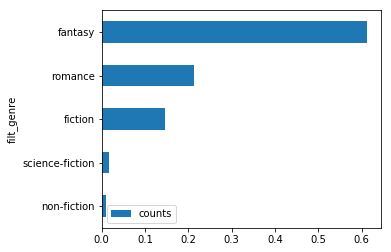

In [74]:
# visualising the fraction of total counts each genre corresponds to
total = clean_genre.groupby('filt_genre').sum().sum()
_ = (
    clean_genre
    .groupby('filt_genre')
    .sum() / total).sort_values(by='counts', ascending=True)\
    .plot(kind='barh', figsize=(5,4)
    )

I will set a threshold of 0.25 to assign main genres (note that this is arbitrary)

In [76]:
# combine all the steps above to create a function
def extract_book_genre_info(entry):
    genre_info = pd.DataFrame(eval(entry))
    genre_info.rename(columns={'@count': 'counts', '@name': 'genre'}, inplace=True)
    search_pattern = '|'.join(genre_filter)
    m_bad_genres = genre_info.genre.str.contains(search_pattern)
    clean_genre = genre_info[~ m_bad_genres].copy()

    clean_genre.reset_index(drop=True, inplace=True)
    clean_genre['filt_genre'] = clean_genre.genre.map(genre_dict)
    clean_genre['counts'] = clean_genre.counts.astype(int)

    total = clean_genre.groupby('filt_genre').sum().sum()
    counts_df = (clean_genre.groupby('filt_genre').sum() / total).sort_values(by='counts')
    book_genre = [i for i in counts_df[counts_df.counts > 0.25].index]
    return book_genre

In [77]:
goodreads_ids_genres = goodreads_ids_genres.drop(index=566, axis=0)
goodreads_ids_genres = goodreads_ids_genres.reset_index(drop=True)

In [78]:
shelves = goodreads_ids_genres.goodreads_shelves

In [79]:
# apply the function to the full dataset
goodreads_ids_genres['book_genres'] = shelves.map(extract_book_genre_info)
goodreads_ids_genres.head()

In [81]:
# saving the dataframe for future use
goodreads_ids_genres.to_csv(CLEAN_BOOK_GENRES_PATH, index=False)